## Log parser

In [1]:
import re
from collections import defaultdict

In [2]:
log_filename = "covid_store.log"
dim = 64, 100
patt_out_line = "[0-9]+ / . / . / (?P<time>[0-9:]+) / [a-zA-Z0-9]+\((?P<x>[0-9]+),(?P<y>[0-9]+)\)\([0-9]+\) / out / +(?P<state>[0-9.-]+) / ([a-zA-Z0-9]+)\([0-9]+\)"

In [3]:
ID_SUSCEPTIBLE = 0
ID_INFECTED = 1
ID_SICK = 8
ID_RECOVERED = 16
ID_DEAD = -1
ID_WALL = -10

In [4]:
def time_str_to_ts(time_str):
  patt_time = "([0-9]{2}):([0-9]{2}):([0-9]{2}):([0-9]{3})(?::[0-9]*)?"
  match = re.match(patt_time, time_str)
  if not match:
    raise RuntimeError("Error converting simulation time")
  tu = list(map(int, match.groups()))
  return tu[3] + tu[2]*1000 + tu[1]*60000 + tu[0]*3600000

def dict_to_states_row(states_dict):
  row = []
  for state in [ID_SUSCEPTIBLE, ID_INFECTED, ID_SICK, ID_RECOVERED, ID_DEAD, ID_WALL]:
    row.append(states_dict[state] if state in states_dict else 0)
  return row


In [5]:
state_count = defaultdict(int)
df_rows = []
curr_states = [[None] * dim[1] for _ in range(dim[0])]

In [6]:
curr_time = None
with open(log_filename, "r") as log_file:
  for line in log_file:
    line = line.strip()
    match = re.match(patt_out_line, line)
    if not match:
      continue
    if curr_time is None:
      curr_time = match.group("time")
    elif curr_time != match.group("time"):
      #print("Changed to " + match.group("time"))

      row = [time_str_to_ts(curr_time)] + dict_to_states_row(dict(state_count.items()))
      df_rows.append(row)

      curr_time = match.group("time")

    x = int(match.group("x"))
    y = int(match.group("y"))
    
    if not curr_states[x][y] is None:
      state_count[curr_states[x][y]] -= 1

    curr_states[x][y] = int(float(match.group("state")))
    state_count[int(float(match.group("state")))] += 1

In [7]:
df_rows[:8]

[[0, 4206, 3, 0, 0, 0, 2191],
 [1, 4199, 10, 0, 0, 0, 2191],
 [2, 4188, 21, 0, 0, 0, 2191],
 [3, 4181, 28, 0, 0, 0, 2191],
 [4, 4177, 32, 0, 0, 0, 2191],
 [5, 4174, 35, 0, 0, 0, 2191],
 [7, 4174, 32, 3, 0, 0, 2191],
 [8, 4174, 25, 7, 0, 1, 2191]]

## Dataframe creation and visualization

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [9]:
columns = ["time", "susceptible", "infected", "sick", "recovered", "dead", "walls"]
df = pd.DataFrame(df_rows, columns=columns)
df = df.set_index("time")
df.head()

,susceptible,infected,sick,recovered,dead,walls
time,,,,,,
0,4206,3,0,0,0,2191
1,4199,10,0,0,0,2191
2,4188,21,0,0,0,2191
3,4181,28,0,0,0,2191
4,4177,32,0,0,0,2191


In [10]:
total_cells = sum(df.loc[0,:])
population = total_cells - df.loc[0,:]["walls"]
print("Total cells: %d, population: %d" % (total_cells, population)) 

Total cells: 6400, population: 4209


In [11]:
df_vis = df.copy()
df_vis = df_vis.drop(["walls"], axis=1)
df_vis = df_vis.divide(population)
df_vis.head()

,susceptible,infected,sick,recovered,dead
time,,,,,
0,0.999287,0.000713,0.0,0.0,0.0
1,0.997624,0.002376,0.0,0.0,0.0
2,0.995011,0.004989,0.0,0.0,0.0
3,0.993348,0.006652,0.0,0.0,0.0
4,0.992397,0.007603,0.0,0.0,0.0


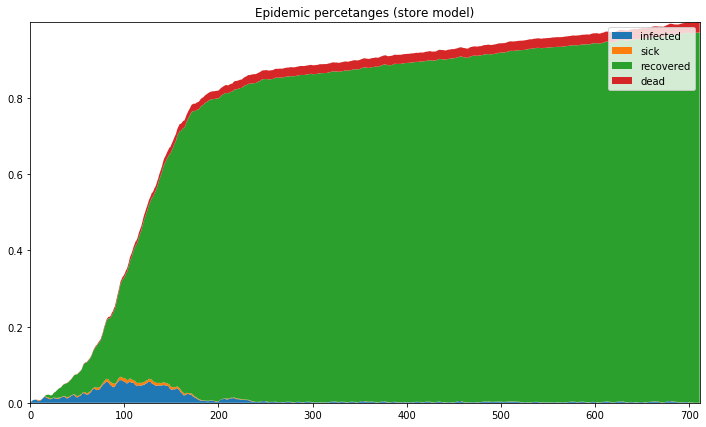

In [15]:
col_names = ["infected", "sick", "recovered", "dead"]
x = list(df_vis.index)
y = np.vstack([df_vis[col] for col in col_names])

fig, ax = plt.subplots(figsize=(12,7))
ax.stackplot(x, y, labels=col_names)
plt.legend(loc='upper right')
plt.margins(0,0)
plt.title('Epidemic percetanges (store model)')
plt.show()

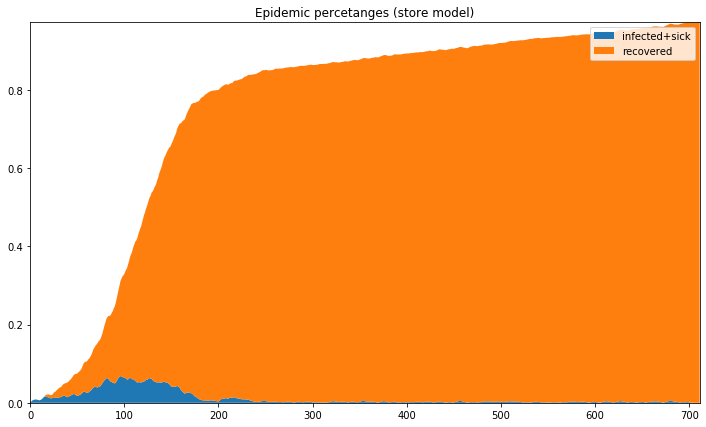

In [16]:
col_names = ["infected+sick", "recovered"]
x = list(df_vis.index)
y = np.vstack([df_vis["infected"]+df_vis["sick"], df_vis["recovered"]])

fig, ax = plt.subplots(figsize=(12,7))
ax.stackplot(x, y, labels=col_names)
plt.legend(loc='upper right')
plt.margins(0,0)
plt.title('Epidemic percetanges (store model)')
plt.show()

#plt.stackplot(list(df_vis.index),  df_vis["infected"]+df_vis["sick"], df_vis["recovered"], labels=col_names)
